# Minicourse of Bayesian Machine Learning for Scientific Research
## Lecture 1

This notebook contains problems and discussions for the course.  We want you to pay attention and participate in the lectures, this is why, on-purpose, notebooks are not self-contained.  It has many comments that should be uncommented and tested, etc.  And many important comments are discussed in the lectures.

This notebook if intended solely for the Minicourse of Bayesian Machine Learning for Scientific Research.  Ezequiel Alvarez (sequialvz@gmail.com)

#### Setup

In [20]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [21]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

## Gaussian Mixtures

In many scientific research analyses one has a mixture of components: the sought signal and some background(s).  This first very simple example intends to give a first step in that direction.  These systems are called Mixture Models and are very important in scientific research.

### Generate data

In [47]:
# Create data sampled from a mixture of gaussians
# define the parameters
np.random.seed(5)
mu1 = 160
sigma1 = 8
mu2 = 185
sigma2 = 10
p = 0.2 # mixture parameter
#sampling
out = []
bernoulli = np.random.binomial(1, p, size=300)
for i in range(len(bernoulli)):
    if bernoulli[i] == 1:
        out.append(np.random.normal(mu1,sigma1))
    else:
        out.append(np.random.normal(mu2,sigma2))

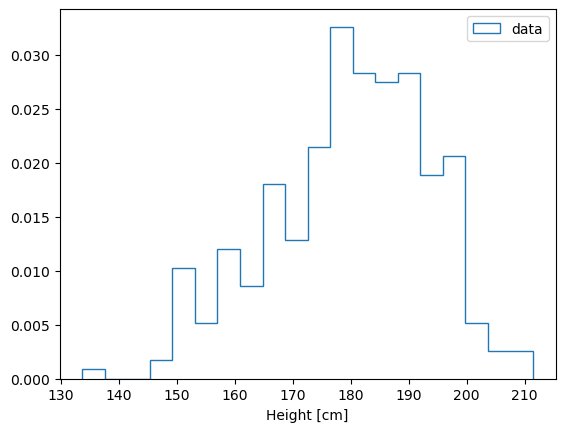

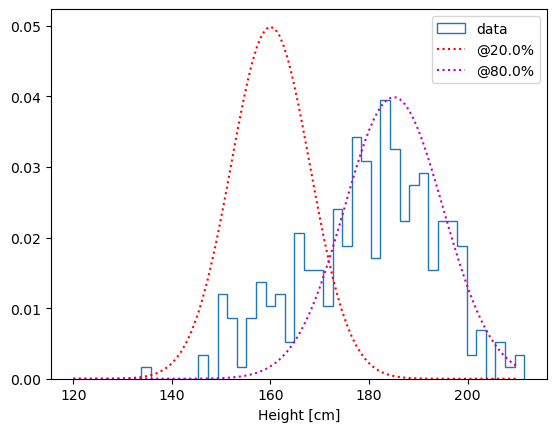

In [48]:
# We plot the data without labels (as we would actually see it!)
x=np.linspace(120,210,100)
plt.hist(out, histtype='step', bins=20, density=1, label='data')
#plt.plot(x, stats.norm.pdf(x,mu0,sigma0), 'r:', label='80%')
#plt.plot(x, stats.norm.pdf(x,mu1,sigma1), 'm:', label='20%')
plt.xlabel('Height [cm]')
plt.legend()
plt.show()

# We plot the data without labels (as we would actually see it!)
x=np.linspace(120,210,100)
plt.hist(out, histtype='step', bins=40, density=1, label='data')
plt.plot(x, stats.norm.pdf(x,mu1,sigma1), 'r:', label='@'+str((p)*100)+'%')
plt.plot(x, stats.norm.pdf(x,mu2,sigma2), 'm:', label='@'+str((1-p)*100)+'%')
plt.xlabel('Height [cm]')
plt.legend()
plt.show()

### Implementing the Gaussian Mixture model

In [59]:
my_mixture="""
data {
 int <lower=0> N;
 vector[N] y;
 real prior_mu1;
 real prior_mu2;
}

parameters {
  ordered[2] mu;  // This tells the sampler that always mu[1] < mu[2]
  //real mu[2];   // Study what happens if we use this line instead of the above  (it is called 'label switching')
  vector<lower=0>[2] sigma;
  real<lower=0, upper=1> theta;
}

model {   
 sigma[1] ~ cauchy(0, 8);  
 sigma[2] ~ cauchy(0,10);
 mu[1] ~ normal(prior_mu1, prior_mu1 * 0.2);
 mu[2] ~ normal(prior_mu2, prior_mu2 * 0.2);
 theta ~ beta(1, 1);  //this is a uniform flat distribution for p in (0,1)
 for (n in 1:N)
   target += log_mix(theta,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""

In [60]:
prior_mu1 = mu1 * 1.2
prior_mu2 = mu2 * 0.7
my_data={'N':len(out),'y':out, 'prior_mu1': prior_mu1, 'prior_mu2': prior_mu2}

In [61]:
model = stan.build(my_mixture, data=my_data, random_seed=1);

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s


In file included from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/tbb/concurrent_unordered_map.h:26,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:10,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/sequi/.cache/httpstan/4.13.0/models/lxl7eu4f/model_lxl7eu4f.cpp:2:
/home/sequi/.local/lib/python3.10/site-packages/httpstan/include/tbb/internal/_concurrent_unordered_impl.h: In instantiation of ‘void tbb::interface5::internal::concurrent_unordered_base<Traits>::internal_init() [

Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s


Building: 7.2s, done.
Messages from stanc:
Warning in '/tmp/httpstan_l0cks7tu/model_lxl7eu4f.stan', line 21, column 1: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [62]:
fit = model.sample(num_chains=4, num_samples=1000)
#fit = model.sample(num_chains=4, num_samples=1000, delta=0.95)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  26% (2100/8000)
Sampling:  48% (3800/8000)
Sampling:  64% (5100/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_wndcvx2o/model_lxl7eu4f.stan', line 23, column 3 to

In [63]:
df = fit.to_frame() 

In [64]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,sigma.1,sigma.2,theta
draws,,,,,,,,,,,,
0,-1212.481340,0.976536,0.087505,4.0,23.0,0.0,1217.754349,178.930232,194.498212,13.563440,5.778027,0.872740
1,-1206.187859,0.711751,0.100209,5.0,47.0,0.0,1210.791996,159.439860,183.330647,8.476329,10.940165,0.181387
2,-1206.484738,0.938566,0.077997,6.0,95.0,0.0,1208.975678,172.875336,187.829356,14.282992,8.343707,0.517717
3,-1210.766236,0.986344,0.084348,4.0,31.0,0.0,1214.765936,163.869904,184.384512,10.292388,10.581101,0.143107
4,-1208.372661,0.997431,0.087505,5.0,47.0,0.0,1213.449998,175.424623,187.761725,14.367311,10.077611,0.595854
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1206.653544,0.987995,0.084348,4.0,15.0,0.0,1208.273833,162.378901,185.406362,9.185361,9.302373,0.204556
3996,-1206.868919,0.796240,0.087505,5.0,43.0,0.0,1210.658822,168.747895,186.871600,12.697947,10.374820,0.357663
3997,-1211.270600,0.913393,0.100209,5.0,31.0,0.0,1215.739532,177.768782,183.914968,15.302272,7.751307,0.692268


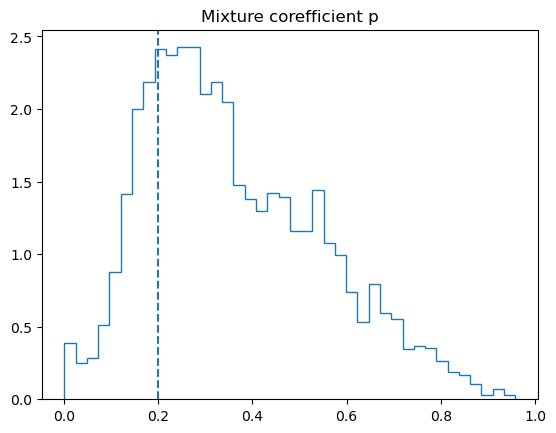

In [65]:
plt.hist(df['theta'], histtype='step', density=1, bins=40)
plt.axvline(x=p, linestyle='dashed')
#plt.axvline(x=1-p, linestyle='dashed')
plt.title('Mixture corefficient p')
plt.show()

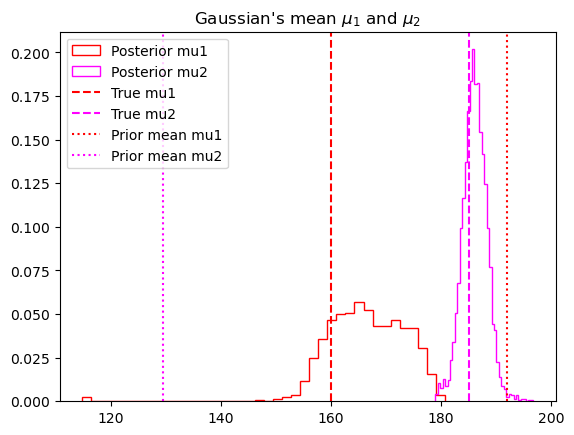

In [66]:
plt.hist(df['mu.1'],histtype='step', bins=40, color='red', density=1, label='Posterior mu1')
plt.hist(df['mu.2'],histtype='step', bins=40, color='magenta', density=1, label='Posterior mu2')
plt.axvline(x=mu1, linestyle='dashed', color='red', label='True mu1')
plt.axvline(x=mu2, linestyle='dashed', color='magenta', label='True mu2')
plt.axvline(x=prior_mu1, linestyle='dotted', color='red', label='Prior mean mu1')
plt.axvline(x=prior_mu2, linestyle='dotted', color='magenta', label='Prior mean mu2')
plt.title("Gaussian's mean $\mu_1$ and $\mu_2$")
plt.legend()
plt.show()

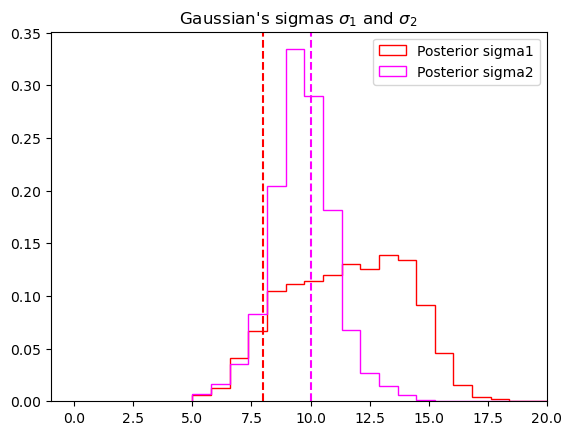

In [67]:
plt.hist(df['sigma.1'],histtype='step', bins=np.linspace(5,20,20), color='red', density=1, label='Posterior sigma1')
plt.hist(df['sigma.2'],histtype='step', bins=np.linspace(5,20,20), color='magenta', density=1, label='Posterior sigma2')
plt.axvline(x=sigma1, linestyle='dashed', color='red')
plt.axvline(x=sigma2, linestyle='dashed', color='magenta')
plt.title("Gaussian's sigmas $\sigma_1$ and $\sigma_2$")
plt.xlim(-1,20)
plt.legend()
plt.show()

### Let's study the sampling

In [58]:
azdata = az.from_pystan(fit)

In [32]:
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],167.444,6.307,156.446,177.621,0.280,0.199,499.0,1228.0,1.01
mu[1],186.298,2.171,182.439,190.536,0.074,0.052,868.0,1226.0,1.00
sigma[0],11.765,2.508,7.307,15.879,0.095,0.068,730.0,1055.0,1.01
sigma[1],9.486,1.392,6.701,12.070,0.055,0.039,660.0,1059.0,1.01
theta,0.388,0.191,0.077,0.735,0.008,0.006,520.0,1082.0,1.01


In [16]:
azdata.posterior

<xarray.Dataset> Size: 168kB
Dimensions:      (chain: 4, draw: 1000, mu_dim_0: 2, sigma_dim_0: 2)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mu_dim_0     (mu_dim_0) int64 16B 0 1
  * sigma_dim_0  (sigma_dim_0) int64 16B 0 1
Data variables:
    mu           (chain, draw, mu_dim_0) float64 64kB 176.0 186.4 ... 185.9
    sigma        (chain, draw, sigma_dim_0) float64 64kB 15.7 8.838 ... 10.45
    theta        (chain, draw) float64 32kB 0.5967 0.7051 ... 0.2535 0.3156
Attributes:
    created_at:                 2024-10-27T21:35:11.093640+00:00
    arviz_version:              0.19.0
    inference_library:          stan
    inference_library_version:  3.10.0
    num_chains:                 4
    num_samples:                1000
    num_thin:                   1
    num_warmup:                 1000
    save_warmup:                0

## Some final observations:

- Mixture models are essential to science
- How would you put a prior on the mixing fractions theta ?
- 'Logmix()' is a very useful function to add log-Likelihoods. Recall that exp(-300) is the smallest positive double() precision! <a href="https://db.apache.org/derby/docs/10.2/ref/rrefsqljdoubleprecision.html#:~:text=Smallest%20DOUBLE%20value%3A%20%2D1.79769E,DOUBLE%20value%3A%202.225E%2D307">(see link)</a>
- The 'target += ' method in the Stan model block is very clear: we are constructing the Likelihood event-by-event
- But there are other models as well!
- Play with ordered_vector
- Play with verifying Rhat is close enough to 1 to trust your sampling
- Play with some sampling control variables such as delta